In [17]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ---------- IO helpers ----------
def step_to_block(step, block_size=32, block_id_base=1):
    block_idx0 = step // block_size
    step_block = step % block_size
    block_id = block_idx0 + block_id_base
    return block_id, step_block

def load_kv_tensor(path):
    obj = torch.load(path, map_location="cpu")
    if torch.is_tensor(obj):
        return obj
    if isinstance(obj, dict):
        for key in ["k", "v", "key", "value", "K", "V"]:
            if key in obj and torch.is_tensor(obj[key]):
                return obj[key]
    raise TypeError(f"Unrecognized content in {path}: {type(obj)}")

def load_step_layer_tensor(records_dir, sample_id, layer, kind, step,
                           block_size=32, block_id_base=1):
    block_id, step_block = step_to_block(step, block_size, block_id_base)
    fname = f"batch_{sample_id}_{block_id}_{step_block}_{layer}_{kind}_previous.pt"
    fpath = os.path.join(records_dir, fname)
    if not os.path.exists(fpath):
        raise FileNotFoundError(f"Missing file: {fpath}")
    T = load_kv_tensor(fpath)

    # allow [1, seq, hidden]
    if T.ndim == 3 and T.shape[0] == 1:
        T = T[0]

    # Expect [seq, hidden]
    if T.ndim != 2:
        raise ValueError(f"Expected [seq, hidden], got {tuple(T.shape)} in {fpath}")

    return T.detach().float()  # float32 on CPU


# ---------- core computation ----------
def make_step_pairs(total_steps: int, pair_mode: str = "neighbor"):
    """
    Returns list of (t_prev, t_cur) pairs.
    pair_mode:
      - "neighbor": (0,1),(1,2),...,(T-2,T-1)
      - "nonoverlap": (0,1),(2,3),... (drops last if odd)
      - "gap2": (0,2),(1,3),... (two-step gap, optional)
    """
    if pair_mode == "neighbor":
        return [(t-1, t) for t in range(1, total_steps)]
    if pair_mode == "nonoverlap":
        return [(t, t+1) for t in range(0, total_steps-1, 2)]
    if pair_mode == "gap2":
        return [(t, t+2) for t in range(0, total_steps-2)]
    raise ValueError(f"Unknown pair_mode: {pair_mode}")

def cosine_sim_per_token(A, B):
    """
    A, B: [seq, hidden]
    returns: [seq] cosine similarity per token
    """
    return F.cosine_similarity(A, B, dim=1, eps=1e-8)

def layer_diff_step_pair_heatmap(
    records_dir: str,
    sample_id: int,
    kind: str,                 # "k" or "v"
    layer1: int,
    layer2: int,
    total_steps: int = 128,
    pair_mode: str = "neighbor",
    block_size: int = 32,
    block_id_base: int = 1,
):
    pairs = make_step_pairs(total_steps, pair_mode=pair_mode)

    # Determine seq_len from first load
    t0a, t0b = pairs[0]
    A1 = load_step_layer_tensor(records_dir, sample_id, layer1, kind, t0a,
                                block_size=block_size, block_id_base=block_id_base)
    seq_len, hidden = A1.shape

    diff = torch.empty((len(pairs), seq_len), dtype=torch.float32)

    # Optional small optimization: cache per layer, per step tensors if you have RAM
    # Here: straightforward loading loop
    for i, (ta, tb) in enumerate(pairs):
        L1_a = load_step_layer_tensor(records_dir, sample_id, layer1, kind, ta,
                                      block_size=block_size, block_id_base=block_id_base)
        L1_b = load_step_layer_tensor(records_dir, sample_id, layer1, kind, tb,
                                      block_size=block_size, block_id_base=block_id_base)

        L2_a = load_step_layer_tensor(records_dir, sample_id, layer2, kind, ta,
                                      block_size=block_size, block_id_base=block_id_base)
        L2_b = load_step_layer_tensor(records_dir, sample_id, layer2, kind, tb,
                                      block_size=block_size, block_id_base=block_id_base)

        sim1 = cosine_sim_per_token(L1_b, L1_a)  # [seq]
        sim2 = cosine_sim_per_token(L2_b, L2_a)  # [seq]

        diff[i] = sim2 - sim1    # signed difference (layer2 - layer1)

    return diff, pairs  # diff shape: [num_pairs, seq_len]


# ---------- plotting ----------
def plot_diff_heatmap(diff, pairs, title="", savepath=None, symmetric=True, arbitrary=True):
    """
    diff: [num_pairs, seq_len]
    pairs: list of (ta, tb)
    """
    M = diff.numpy()

    if arbitrary:
        vmax = 1.0
    else:
        vmax = float(torch.max(torch.abs(diff)).item())
    # end

    if symmetric:
        vmin = -vmax
    else:
        vmin = float(diff.min().item())
        vmax = float(diff.max().item())

    plt.figure(figsize=(10, 6), dpi=150)
    im = plt.imshow(M, aspect="auto", cmap="RdYlGn", vmin=vmin, vmax=vmax)
    plt.colorbar(im, fraction=0.046, pad=0.04, label="(layer2 - layer1) cosine-sim diff")

    plt.xlabel("token position")
    plt.ylabel("step pair (tb vs ta)")

    # Light y tick labeling (avoid clutter)
    if len(pairs) <= 16:
        yticks = list(range(len(pairs)))
    else:
        stride = max(1, len(pairs) // 8)
        yticks = list(range(0, len(pairs), stride))
    ylabels = [f"{pairs[i][1]} vs {pairs[i][0]}" for i in yticks]
    plt.yticks(yticks, ylabels)

    plt.title(title)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show()


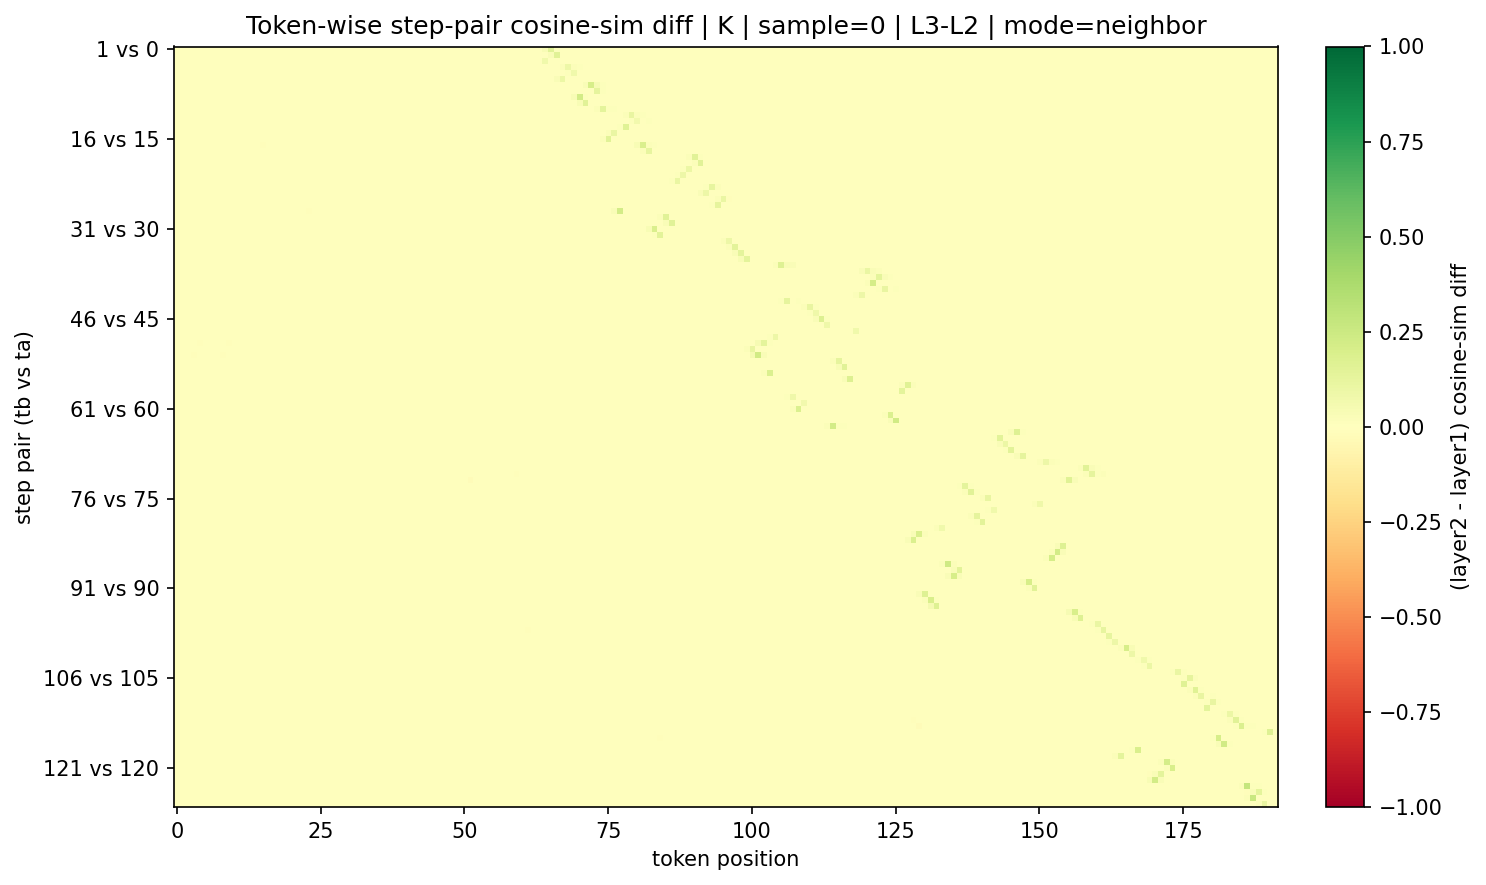

In [18]:
records_dir = "kv_states_20260219_consistency"
sample_id = 0
kind = "k"          # or "v"

layer1 = 2
layer2 = 3

diff, pairs = layer_diff_step_pair_heatmap(
    records_dir=records_dir,
    sample_id=sample_id,
    kind=kind,
    layer1=layer1,
    layer2=layer2,
    total_steps=128,
    pair_mode="neighbor",   # (t-1,t). If you want (0,1),(2,3)... use "nonoverlap".
    block_id_base=0,        # matches your filename example
)

plot_diff_heatmap(
    diff, pairs,
    title=f"Token-wise step-pair cosine-sim diff | {kind.upper()} | sample={sample_id} | L{layer2}-L{layer1} | mode=neighbor",
    savepath=f"diff_heatmap_{kind}_b{sample_id}_L{layer2}-L{layer1}_neighbor.png",
    symmetric=True,
    arbitrary=True
)
